In [1]:
%run batter_data.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import kerastuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA

from tensorflow import keras

feature, target = batter_data("KT")

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A va

In [3]:
feature.columns

Index(['RUN', 'KK', 'MONEY_BAT', 'AGE_VA_BAT', 'K/PA', 'ISO', 'BABIP_BAT',
       'BPF', 'BS_PCA', 'PA_PCA'],
      dtype='object')

In [13]:
trainFeature = feature.loc[0:feature.shape[0]-120]
trainTarget = target.loc[0:feature.shape[0]-120]

validFeature = feature.loc[feature.shape[0]-120:feature.shape[0]-20].reset_index(drop = True)
validTarget = target.loc[feature.shape[0]-120:feature.shape[0]-20].reset_index(drop = True)

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)
trainFeature.shape

(482, 13)

In [14]:
scaler = MinMaxScaler()
res = scaler.fit(trainFeature)
res = scaler.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = scaler.transform(validFeature)
validFeature = pd.DataFrame(res, columns = validFeature.columns, index = list(validFeature.index.values))

res = scaler.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

In [ ]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return super().call(inputs, training = True)
    
def make_model(hp) :
    model = keras.Sequential()

    model.add(keras.layers.Input(shape = (trainFeature.shape[1])))
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
                               activation="selu", kernel_initializer = "lecun_normal"))
        model.add(MCDropout(rate = .2))

    model.add(keras.layers.Dense(1, activation = None))

    optimizer = keras.optimizers.Nadam(hp.Choice("learning_rate", values = [0.005, 0.001, 0.0005, 0.0001]))

    model.compile(optimizer = optimizer, loss = keras.losses.Huber())
    return model

tuner = kt.RandomSearch(make_model, objective = "val_loss", max_trials = 21, executions_per_trial = 11)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, mode = "min", restore_best_weights = True)

#history = model.fit(trainFeature, trainTarget, epochs = 700, validation_data = [validFeature, validTarget], shuffle = False,
#                    use_multiprocessing = True, batch_size = 128, callbacks = [early_stop])
tuner.search(trainFeature, trainTarget, epochs = 500, validation_data = (validFeature, validTarget), shuffle = False, use_multiprocessing = True, callbacks = [early_stop])


Train on 482 samples, validate on 101 samples
Epoch 1/500
482/482 [==============================] - ETA: 7s - loss: 1.120 - ETA: 0s - loss: 1.027 - 2s 4ms/sample - loss: 0.9916 - val_loss: 0.8730
Epoch 2/500
482/482 [==============================] - ETA: 0s - loss: 0.843 - ETA: 0s - loss: 0.885 - 0s 292us/sample - loss: 0.8751 - val_loss: 0.6319
Epoch 3/500
482/482 [==============================] - ETA: 0s - loss: 0.856 - ETA: 0s - loss: 0.742 - 0s 272us/sample - loss: 0.7333 - val_loss: 0.6151
Epoch 4/500
482/482 [==============================] - ETA: 0s - loss: 0.732 - ETA: 0s - loss: 0.646 - 0s 182us/sample - loss: 0.6491 - val_loss: 0.8005
Epoch 5/500
482/482 [==============================] - ETA: 0s - loss: 0.726 - ETA: 0s - loss: 0.675 - 0s 283us/sample - loss: 0.6581 - val_loss: 0.5860
Epoch 6/500
482/482 [==============================] - ETA: 0s - loss: 0.704 - ETA: 0s - loss: 0.633 - 0s 172us/sample - loss: 0.6209 - val_loss: 0.5864
Epoch 7/500
482/482 [=================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train on 482 samples, validate on 101 samples
Epoch 1/500
482/482 [==============================] - ETA: 11s - loss: 1.65 - ETA: 0s - loss: 1.2613 - 2s 4ms/sample - loss: 1.2294 - val_loss: 1.1838
Epoch 2/500
482/482 [==============================] - ETA: 0s - loss: 1.185 - ETA: 0s - loss: 1.090 - 0s 185us/sample - loss: 1.0601 - val_loss: 0.9174
Epoch 3/500
482/482 [==============================] - ETA: 0s - loss: 1.264 - ETA: 0s - loss: 0.914 - 0s 175us/sample - loss: 0.9100 - val_loss: 0.8283
Epoch 4/500
482/482 [==============================] - ETA: 0s - loss: 0.961 - ETA: 0s - loss: 0.866 - 0s 174us/sample - loss: 0.8580 - val_loss: 0.9279
Epoch 5/500
482/482 [==============================] - ETA: 0s - loss: 1.069 - ETA: 0s - loss: 0.857 - 0s 172us/sample - loss: 0.8410 - val_loss: 0.9336
Epoch 6/500
482/482 [==============================] - ETA: 0s - loss: 0.891 - ETA: 0s - loss: 0.807 - 0s 182us/sample - loss: 0.8283 - val_loss: 0.7027
Epoch 7/500
482/482 [================

In [ ]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
model.summary()

In [ ]:
result = np.zeros(shape = (20, ))
for i in range(100) :
    best = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best)
    model.fit(trainFeature, trainTarget, epochs = 500, validation_data = (validFeature, validTarget), shuffle = False, use_multiprocessing = True,
                    callbacks = [early_stop], batch_size = 20)
    result += model.predict(testFeature).reshape(20, )
result /= 100
result.mean()

In [62]:
testTarget.mean()

0.2830805126315159

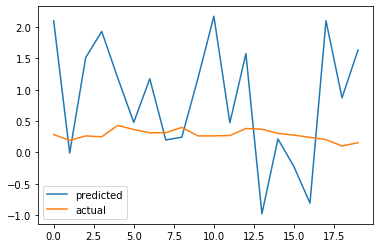

In [63]:
plt.plot(result, label = "predicted")
plt.plot(testTarget.reset_index(drop = True), label = "actual")
plt.legend()

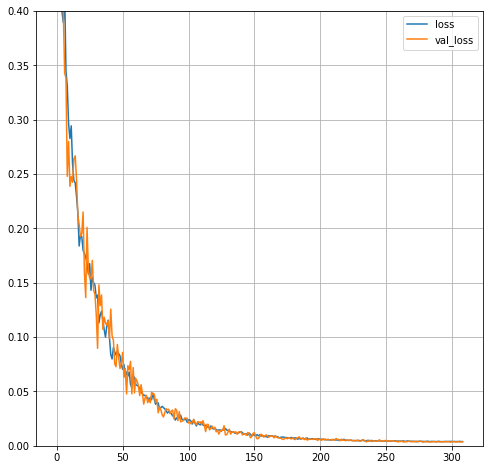

In [9]:
pd.DataFrame(history.history).plot(figsize = (8, 8))
plt.grid(True)
plt.gca().set_ylim(0, .4)
plt.show()

In [10]:
trainTarget.mean()

0.2692722882088851